In [1]:
import numpy as np
from scipy.stats import gennorm, norm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import binned_statistic

In [5]:
# Fast binning function
def bin_data(data, min_ct=10, max_bins=10, direction='descending', noise=1E-6):
    """
    Bin data for use in NA regression
    
    parameters
    ----------
    
    data: (array-like)
        Data to bin. Must be castable as a one-dimensional numpy array or floats.
        
    min_ct: (int > 0 and <= N/2)
        Minimum number of data points to include in each bin.
        
    max_bins: (int >= 2)
        Maximum number of bins. Specifically, this determines the minimum bin length, which is 
        is given by min_length = (max(data)-min(data))/max_bins.
        
    direction: (str)
        Specifies direction in which bins are computed. Must be "ascending" or "descending".
    
    noise: (float >= 0 or None)
        Noise to add to data to avoid ties, in units of the data's standard deviation.
        
    returns
    -------
    
    data_bins: (np.ndarray)
        Array listing the bins that each data point is assigned to.
        
    bin_df: (pd.DataFrame)
        Dataframe listing bin boundaries, counts, and lengths.
    
    """
        
    # Cast data as np.array
    data = np.array(data)
    
    # Multiply noise by the standard deviation of the data
    noise *= np.std(data)
        
    # Add purturbation to data to avoid ties
    data = np.array(data) + noise*np.random.randn()
        
    # Get number of data points
    N = len(data)
    
    # Check min_ct
    assert min_ct <= N/2
    
    # Check max_bins 
    assert max_bins > 0
    assert max_bins >= 2
    
    # Compute min_length
    span = max(data)-min(data)+noise # Note the noise cussion. 
    min_length = span/max_bins
    
    # Sort data
    if direction=='descending':
        sorted_data = np.sort(-data)
    elif direction=='ascending':
        sorted_data = np.sort(data)
    else:
        assert False, 'Invalid value for direction. Must be "ascending" or "descending"'
    
    # Compute edges
    edge_min = sorted_data[0]-noise/2
    edge_max = sorted_data[-1]+noise/2

    # Initialize n, edges, and cts
    n = -1
    edge = edge_min
    edges = np.array([edge])
    ns = np.array([n])
    while (n < N-min_ct-1) and (edge < edge_max-min_length):

        n_new_a = n + min_ct
        edge_new_a = .5*(sorted_data[n_new_a]+sorted_data[n_new_a+1])

        edge_new_b = edge + min_length
        n_new_b = np.searchsorted(sorted_data, edge_new_b)

        n = max(n_new_a, n_new_b)
        edge = max(edge_new_a, edge_new_b)

        # Record edge and n
        edges = np.append(edges,edge)
        ns = np.append(ns,n)

    # Add upper bound to edges if needed
    if (n < N) and (edge < edge_max):
        edges = np.append(edges, edge_max)
        ns = np.append(ns, N)

    # Remove second-to-last edge if cts in last bin is too small
    cts = np.diff(ns)
    if cts[-1] < min_ct:
        edges = np.delete(edges,-2)

    # If descending, reverse edges. Note that this might mess up cts a bit.
    if direction=='descending':
        edges = -edges[::-1]
        
    # Make sure that cts agrees with histogram
    cts, _ = np.histogram(data, edges)

    # Create a dataframe to hold results
    bin_df = pd.DataFrame()
    bin_df['count'] = cts
    bin_df['left_in'] = edges[:-1]
    bin_df['right_ex'] = edges[1:]
    bin_df['length'] = bin_df['right_ex'] - bin_df['left_in'] 
    
    # Compute bin index for each data point
    _, _, data_bins = binned_statistic(data, data, statistic='mean', bins=edges, range=None)
    
    # Return dataframe
    return data_bins-1, bin_df

,count,left_in,right_ex,length
0,281,-8.108627,-3.771522,4.337105
1,539,-3.771522,-2.788280,0.983242
2,1049,-2.788280,-1.805037,0.983242
3,1543,-1.805037,-0.821795,0.983242
4,1909,-0.821795,0.161447,0.983242
5,1885,0.161447,1.144690,0.983242
6,1470,1.144690,2.127932,0.983242
7,871,2.127932,3.111175,0.983242
8,445,3.111175,4.094417,0.983242
9,208,4.094417,5.077660,0.983242


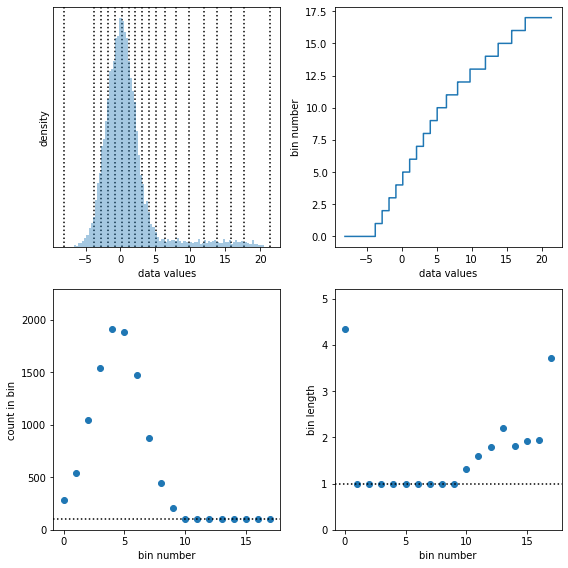

In [6]:
### Test bin_data function on simulated data ###

### Simulate data

# Generate signal data
N_signal = int(1E3)
signal_data = 10*(1+gennorm(beta=8).rvs(N_signal))

# Generate background data
N_background = int(1E4)
background_data = 2*norm().rvs(N_background)

# Gather into all N and shuffle
data = np.concatenate([signal_data, background_data])
np.random.shuffle(data)

### Bin data

min_ct = 100
max_bins = 30
data_bins, bin_df = bin_data(data, 
                  min_ct = min_ct,
                  max_bins = max_bins,
                  direction='descending')

### Plot results

# Create figure and axes
fig, axs = plt.subplots(2,2, figsize=[8,8])
axs = axs.ravel()

# Plot data histogram and edge locations
ax = axs[0]
sns.distplot(data, bins=100, ax=ax, kde=False)
edges = bin_df['left_in'].values
edges = np.append(edges,bin_df['right_ex'].values[-1])
for edge in edges:
    ax.axvline(edge, linestyle=':', color='k', zorder=-100)
ax.set_yticks([])
ax.set_xlabel('data values')
ax.set_ylabel('density')
    
# Plot bin nubmers against data values
ax = axs[1]
ix = np.argsort(data)
ax.step(data[ix],data_bins[ix])
ax.set_ylabel('bin number')
ax.set_xlabel('data values')
    
# Plot counts per bin for each bin
ax = axs[2]
x = bin_df.index
y = bin_df['count']
ax.plot(x,y,'o')
ax.set_ylim([0, max(y)*1.2])
ax.axhline(min_ct, color='k', linestyle=':')
ax.set_ylabel('count in bin')
ax.set_xlabel('bin number')

# Plot bin length for each bin
ax = axs[3]
x = bin_df.index
y = bin_df['length']
ax.plot(x,y,'o')
ax.set_ylim([0, max(y)*1.2])
min_length = (max(data)-min(data))/max_bins
ax.axhline(min_length, color='k', linestyle=':')
ax.set_ylabel('bin length')
ax.set_xlabel('bin number')

# Save figure
fig.tight_layout()
fig.savefig('adaptive_binning.pdf')

# Show bin_df dataframe
bin_df